In [46]:
import pandas as pd;
import numpy as np;
import os
import requests
import bs4 as bs
import nltk
import re
import time
import sys
import logging
import multiprocessing;
from wordcloud import WordCloud, ImageColorGenerator
from itertools import cycle;

from gensim.models import word2vec;


from nltk.corpus import words, stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, sent_tokenize, pos_tag
#from gensim import corpora
import spacy
#spacy.load('en')
from spacy.lang.en import English

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KDTree;

import pyLDAvis.gensim
import warnings
import pickle
import gensim
from nltk.corpus import wordnet as wn
from gensim import corpora

import matplotlib.pyplot as plt

from gensim.models import Word2Vec 

warnings.filterwarnings('ignore')

# change the name of the folder you have all the filings in

In [2]:
folder_name = "300_filings"

In [3]:
def load_filings(folder_name):
    filings = []
    files = os.listdir(folder_name)
    for file in files:
        filing = open(folder_name + '/' + file).read()
        filings.append(filing)
    return filings

#### loads the files

In [4]:
files = load_filings(folder_name)

In [5]:
def get_text_from_file(file):
    page_soup = bs.BeautifulSoup(file, 'lxml')
    divs = page_soup.find_all('div')
    all_text = []
    for div in divs:
        text = div.getText()
        if len(text) > 200 and text[0] != '\xa0':
            all_text.append(text)
    return all_text

def combine_text(text):
    file = ""
    for i in range(len(text)):
        ## removes all the /xa0 /n /t garbage and some extra spaces
        cleaner_text = re.sub('\s+', ' ', text[i]).strip()
        file = file + " " + cleaner_text
        
    return file

def get_all_files(files):
    all_files = []
    for file in files:
        text = get_text_from_file(file)
        filing = combine_text(text)
        
        all_files.append(filing)
        
    return all_files

#### Gets the files and scrapes the text so it's semi-readable -- takes a couple minutes for 300

In [6]:
all_files = get_all_files(files)

In [7]:
more_stop_words = ['company','months','products','operations','income','period','sales','market','business','stock','results',
                  'revenue','shares','share','revenues','assets','statements','value','costs','product','quarter','increase',
                  'expense','customers','performance','interest','charges','price','compensation','agreement','property','amount',
                  'markets','information','expenses','facility','customer','taxes','demand','payments',
                  'stringitemtype','textblockitemtype']

## Check the maxlength of all the SEC files first

The max length for the 300 I checked was < 2 million. We can only look at 999,999 at a time so I'll have to slightly alter the prepare_text() function for if there's a longer report.

In [8]:
max_length = 0
for file in all_files:
    length = len(file)
    if length > max_length:
        max_length = length
        
max_length

1407810

In [9]:
en_stop = nltk.corpus.stopwords.words('english')
en_stop.extend(more_stop_words)
parser = English()

def tokenize(text):
    '''
    Separates each word from the others, making them lower case and removing URLs and possible screen names that show up.
    '''

    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

def prepare_text(text):
    '''
    Tokenizes the text, removes short words, removes stop words,
    and then gets the lemma of each word.
    '''

    if len(text)> 2*(10**6)-1 :
        print(len(text))
    
    if len(text)> 10**6 - 1 :
        text1 = text[:999999]
        text2 = text[999999:]
        tokens = tokenize(text1) + tokenize(text2)
    else:
        tokens = tokenize(text)
        
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token[0]!='-']
    tokens = [token for token in tokens if token[0]!='x']
    tokens = [token for token in tokens if token not in en_stop]
    
    pos_tags = nltk.pos_tag(tokens)
    tokens = [pos_tag[0] for pos_tag in pos_tags if pos_tag[1][0] == "N"]
    
    final_text = ""
    
    #for token in tokens:
    #    final_text = final_text + " " + token
    
    ## do we want lemma?
    ##tokens = [get_lemma(token) for token in tokens]
    return tokens

def prepare_all(all_files):
    prepared_filings = []
    for file in all_files:
        tokens = prepare_text(file)
        prepared_filings.append(tokens)
    
    return prepared_filings

In [10]:
def get_lda_display(prepared_filings,NUM_TOPICS = 10):
    '''
    displays a lda plot for the reviews
    '''

    dictionary = corpora.Dictionary(prepared_filings)
    corpus = [dictionary.doc2bow(text) for text in prepared_filings]

    pickle.dump(corpus, open('corpus.pkl', 'wb'))
    dictionary.save('dictionary.gensim')

    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
    ldamodel.save('model5.gensim')
    topics = ldamodel.print_topics(num_words=5)


    dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
    corpus = pickle.load(open('corpus.pkl', 'rb'))
    lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
    lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
    #pyLDAvis.display(lda_display)
    return lda_display

# 25 minutes to run

In [11]:
prepared_files = prepare_all(all_files)

In [12]:
lda_display = get_lda_display(prepared_files, 10)
pyLDAvis.display(lda_display)

In [13]:
def prepare_text_for_kmeans(text):
    '''
    Tokenizes the text, removes short words, removes stop words, and then gets the lemma of each word.
    '''
    
    if len(text)> 2*(10**6)-1 :
        print(len(text))
    
    if len(text)> 10**6 - 1 :
        text1 = text[:999999]
        text2 = text[999999:]
        tokens = tokenize(text1) + tokenize(text2)
    else:
        tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    
    pos_tags = nltk.pos_tag(tokens)
    tokens = [pos_tag[0] for pos_tag in pos_tags if pos_tag[1][0] == "N"]
    
    final_text = ""
    
    for token in tokens:
        final_text = final_text + " " + token
    
    ## do we want lemma?
    ##tokens = [get_lemma(token) for token in tokens]
    return final_text

# Takes a long ass time too

In [14]:
text_data = []
for file in all_files:
    tokens = prepare_text_for_kmeans(file)
    text_data.append(tokens)

In [15]:
tfidf = TfidfVectorizer()
tfidf_model = tfidf.fit_transform(text_data)

tfidf_model.shape

(328, 16592)

In [16]:
kmeans4 = KMeans(n_clusters=4).fit_predict(tfidf_model)
PCA4 = PCA(n_components=2).fit_transform(tfidf_model.todense())

kmeans2 = KMeans(n_clusters=2).fit_predict(tfidf_model)
PCA2 = PCA(n_components=2).fit_transform(tfidf_model.todense())

Text(0.5, 1.0, '4 Clusters')

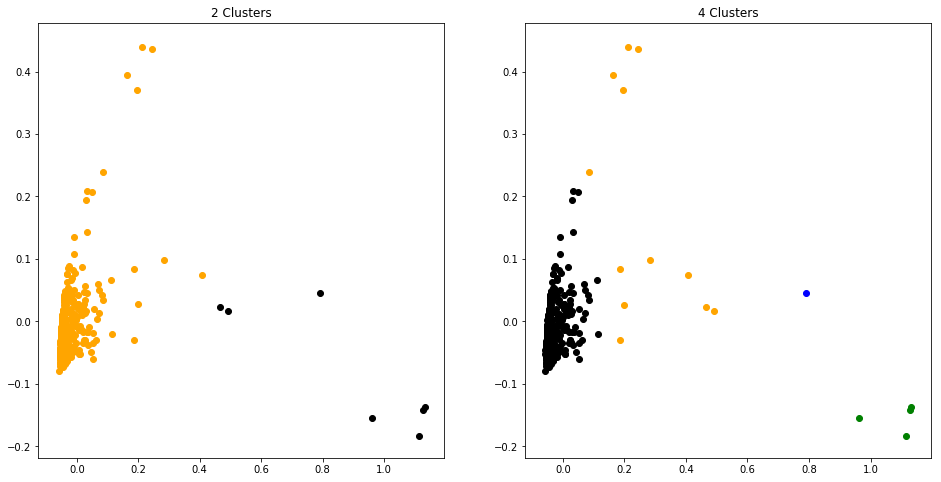

In [17]:
colors = ['orange', 'black', 'green', 'blue']

fig, ax = plt.subplots(1,2, figsize=(16,8))
for cls, col in enumerate(colors[:4]):
    cls2 = PCA2[kmeans2 == cls]
    cls4 = PCA4[kmeans4 == cls]
    ax[0].scatter(cls2[:,0], cls2[:,1], color=col)
    ax[1].scatter(cls4[:,0], cls4[:,1], color=col)
ax[0].set_title("2 Clusters")
ax[1].set_title("4 Clusters")

In [28]:
start = time.time();
#Set the logging format to get some basic updates.
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)


num_features = 100;    # Dimensionality of the hidden layer representation
min_word_count = 40;   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count();       # Number of threads to run in parallel set to total number of cpus.
context = 5          # Context window size (on each side)                                                       
downsampling = 1e-3   # Downsample setting for frequent words


# Initialize and train the model. 
#The LineSentence object allows us to pass in a file name directly as input to Word2Vec,
#instead of having to read it into memory first.

print("Training model...");
model = word2vec.Word2Vec(text_data, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling);

# We don't plan on training the model any further, so calling 
# init_sims will make the model more memory efficient by normalizing the vectors in-place.
model.init_sims(replace=True);
# Save the model
model_name = "model_full_reddit";
model.save(model_name);
print('Total time: ' + str((time.time() - start)) + ' secs')

2019-07-06 15:16:54,324 : INFO : collecting all words and their counts
2019-07-06 15:16:54,326 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2019-07-06 15:16:54,327 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Training model...


2019-07-06 15:16:58,878 : INFO : collected 91 word types from a corpus of 60064404 raw words and 328 sentences
2019-07-06 15:16:58,878 : INFO : Loading a fresh vocabulary
2019-07-06 15:16:58,879 : INFO : min_count=40 retains 69 unique words (75% of original 91, drops 22)
2019-07-06 15:16:58,879 : INFO : min_count=40 leaves 60064165 word corpus (99% of original 60064404, drops 239)
2019-07-06 15:16:58,881 : INFO : deleting the raw counts dictionary of 91 items
2019-07-06 15:16:58,881 : INFO : sample=0.001 downsamples 23 most-common words
2019-07-06 15:16:58,882 : INFO : downsampling leaves estimated 10185983 word corpus (17.0% of prior 60064165)
2019-07-06 15:16:58,897 : INFO : estimated required memory for 69 words and 100 dimensions: 89700 bytes
2019-07-06 15:16:58,898 : INFO : resetting layer weights
2019-07-06 15:16:58,900 : INFO : training model with 4 workers on 69 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2019-07-06 15:16:59,907 : INFO : EPOCH 

Total time: 13.436852931976318 secs


In [29]:
Z = model.wv.syn0;
print(Z[0].shape)
Z[0]

(100,)


array([ 0.21914445,  0.03542732, -0.03822474,  0.22916082, -0.09578676,
        0.00377042,  0.0708575 ,  0.22565342,  0.04535487, -0.0517634 ,
        0.06215646,  0.22000337, -0.07593663, -0.22124642, -0.06067998,
       -0.09273165, -0.08539207,  0.02169309, -0.16211215,  0.09194302,
       -0.10899527,  0.09610994, -0.0424668 ,  0.00554123, -0.08759934,
        0.17816076, -0.0471601 ,  0.08783869,  0.2815079 , -0.11715411,
        0.03284035, -0.23284048,  0.12196961, -0.11585545,  0.11270392,
        0.03992243, -0.02589712, -0.05610647, -0.01023335,  0.03205722,
        0.14976645,  0.06541546,  0.05053723,  0.11092124, -0.09971935,
       -0.00228762,  0.12697421,  0.08518986, -0.03654179, -0.18256895,
       -0.03922537,  0.02074262, -0.05576208,  0.07890381,  0.02988901,
       -0.08709054,  0.10439444, -0.10068551, -0.02977426,  0.11720671,
       -0.03851785,  0.02857374,  0.00574931, -0.08699897, -0.1538303 ,
       -0.09370774,  0.02372007,  0.16019325,  0.08166562, -0.11

In [30]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;

In [31]:
centers, clusters = clustering_on_wordvecs(Z, 50);
centroid_map = dict(zip(model.wv.index2word, clusters));

In [40]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);
#Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];
#Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
#A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    
    return df;

In [42]:
top_words = get_top_words(model.wv.index2word, 5, centers, Z);

In [48]:
def display_cloud(cluster_num, cmap):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num).zfill(2)]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')

In [51]:
cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])
for i in range(50):
    col = next(cmaps);
    display_cloud(i+1, col)

KeyError: 'Cluster #01'

In [53]:
print(centers,clusters)

[[ 2.4267250e-01  1.8778761e-01 -4.1130930e-05 ... -2.2907775e-02
   4.3836523e-02 -1.0111004e-01]
 [ 1.5177137e-01 -1.1289017e-01  4.9177101e-01 ... -6.2232122e-02
   1.5863526e-01 -2.8940758e-02]
 [-3.4386244e-01 -1.9174937e-02 -4.2155248e-01 ...  5.5652045e-02
  -1.2485397e-01  9.4768807e-02]
 ...
 [ 2.6794216e-01  5.6121875e-02  4.3361402e-01 ... -9.5956855e-02
   1.5869272e-01 -1.2733772e-01]
 [ 2.4356541e-01  1.1851978e-01  3.2380739e-01 ...  6.0401730e-02
   1.8819520e-02  3.2113399e-02]
 [ 2.6217669e-01  1.1665332e-01 -5.4573443e-02 ... -1.1409028e-01
   1.1955918e-01 -1.6042970e-01]] [14 39 30 27 18 38 43  9 21 44  2  3 31 34  6 28 25 24 46 29 36 36  1 47
 42 23 19 40 22 37 37  0  0  0  0  0  0  0  0  0 41  0  0  0 49  0 37 11
 33 12 12 37  0 45  5 48 26 35 20 16 41  4 13 15  8  7 32 10 17]


In [54]:
top_words

,Cluster #0,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9,...,Cluster #40,Cluster #41,Cluster #42,Cluster #43,Cluster #44,Cluster #45,Cluster #46,Cluster #47,Cluster #48,Cluster #49
1,3,v,p,d,[,*,l,"""",#,c,...,j,.,q,r,o,–,m,w,;,﻿
2,2,w,-,t,;,%,y,r,r,o,...,v,@,k,e,c,',l,v,&,0
3,4,e,g,o,a,&,m,q,0,-,...,,&,w,l,d,",",y,e,’,1
4,6,q,a,i,\,.,x,b,s,d,...,;,2,v,w,i,7,x,q,,5
5,5,j,h,c,—,/,e,a,"""",i,...,n,1,e,q,-,@,e,k,*,4
